In [33]:
# Imports
import json, math, random, re
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Config (edit paths)
CSV_A   = "/home/op98/protein_design/dataset/PP/biochemical/dd_partnerA_biophysics_v2020.csv"
CSV_B   = "/home/op98/protein_design/dataset/PP/biochemical/dd_partnerB_biophysics_v2020.csv"
TARGETS = "/home/op98/protein_design/topology/mGLI-PP/src/data/data_files/binding_affinity_two_proteins.tsv"     # must have columns: pdb_id, delta_G
OUT_DIR = "/home/op98/protein_design/topology/mGLI-PP/notebooks"

SEED        = 42
VAL_SPLIT   = 0.15
TEST_SPLIT  = 0.15
BATCH_SIZE  = 64
LR          = 3e-4
WEIGHT_DECAY= 1e-4
EPOCHS      = 300
PATIENCE    = 30
CLIP_Q      = (0.001, 0.999)  # robust clipping quantiles

USE_BFACTORS_AS_FEATURES = True  # set False to ignore B-factor columns

out = Path(OUT_DIR); out.mkdir(parents=True, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)



Device: cpu


In [34]:
FEATURE_COLS = [f"feature_{i}" for i in range(1, 95)]

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def normalize_pdb_id(x: str) -> str:
    """
    Normalize various ID forms to 4-char PDB code (lowercase).
    Examples handled:
      '1FC2', '1fc2', '1FC2_A:B', ' pdb1fc2 ', '1fc2-chainA', etc.
    """
    s = str(x).strip().lower()
    # common patterns: take first 4 consecutive alnum chars
    m = re.search(r'([0-9a-z]{4})', s)
    return m.group(1) if m else s

def _detect_id_col(cols: List[str]) -> str:
    for k in ("ID", "pdb_id", "complex_id", "id"):
        if k in cols: return k
    raise ValueError(f"Could not detect an ID column in: {cols[:8]} ...")

def load_feature_csv(path: str) -> pd.DataFrame:
    """
    Load per-protein features CSV -> DataFrame indexed by NORMALIZED 4-char PDB id (JOIN_ID).
    Deduplicates by taking mean per normalized ID.
    """
    df = pd.read_csv(path, sep=None, engine="python")
    df.columns = [c.strip() for c in df.columns]
    id_col = _detect_id_col(list(df.columns))
    missing = [c for c in FEATURE_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"{path} missing feature columns, e.g. {missing[:5]} (total {len(missing)})")
    df = df[[id_col] + FEATURE_COLS].copy()
    for c in FEATURE_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["JOIN_ID"] = df[id_col].apply(normalize_pdb_id)
    # Group by normalized ID; average duplicates
    df = df.groupby("JOIN_ID", as_index=True)[FEATURE_COLS].mean(numeric_only=True)
    return df.sort_index()

def compute_metrics(y_true: torch.Tensor, y_pred: torch.Tensor) -> Dict[str, float]:
    with torch.no_grad():
        mse = nn.functional.mse_loss(y_pred, y_true).item()
        mae = nn.functional.l1_loss(y_pred, y_true).item()
        rmse = math.sqrt(mse)
        y_bar = torch.mean(y_true)
        ss_tot = torch.sum((y_true - y_bar) ** 2)
        ss_res = torch.sum((y_true - y_pred) ** 2)
        r2 = 1.0 - (ss_res / ss_tot).item() if ss_tot.item() > 0 else float("nan")
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MSE": mse}


In [35]:
set_seed(SEED)

# Load features
df_a = load_feature_csv(CSV_A)
df_b = load_feature_csv(CSV_B)

# Load targets, standardize headings, normalize IDs
df_t = pd.read_csv(TARGETS, sep=None, engine="python")
df_t.columns = [c.strip() for c in df_t.columns]
rename_map = {}
if "PDB_ID" in df_t.columns: rename_map["PDB_ID"] = "pdb_id"
if "ΔG_kJ/mol" in df_t.columns: rename_map["ΔG_kJ/mol"] = "delta_G"
df_t = df_t.rename(columns=rename_map)

need_cols = ["pdb_id", "delta_G"]
for col in need_cols:
    if col not in df_t.columns:
        raise ValueError(f"targets must contain '{col}'")

# optional extra columns
extra_cols = []
if USE_BFACTORS_AS_FEATURES:
    for c in ["Avg_Bfactor_Total", "Avg_Bfactor_Interface"]:
        if c in df_t.columns:
            extra_cols.append(c)

# normalize target IDs
df_t["JOIN_ID"] = df_t["pdb_id"].apply(normalize_pdb_id)

# Keep only rows that exist in BOTH A and B
common = set(df_a.index) & set(df_b.index) & set(df_t["JOIN_ID"])
dropped = len(df_t) - sum(df_t["JOIN_ID"].isin(common))
if dropped > 0:
    print(f"[INFO] Dropping {dropped} target rows not present in A & B.")
df_t = df_t[df_t["JOIN_ID"].isin(common)].reset_index(drop=True)

print("A:", df_a.shape, "B:", df_b.shape, "Targets (after align):", df_t.shape, "Common IDs:", len(common))


[INFO] Dropping 209 target rows not present in A & B.
A: (2570, 94) B: (2570, 94) Targets (after align): (1622, 5) Common IDs: 1622


In [36]:
def build_matrix(df_t, df_a, df_b, extra_cols):
    # Base feature blocks
    A = df_a.loc[df_t["JOIN_ID"], FEATURE_COLS].to_numpy(dtype=np.float64)
    B = df_b.loc[df_t["JOIN_ID"], FEATURE_COLS].to_numpy(dtype=np.float64)

    # Engineered pairwise features
    SUM   = A + B
    DIFF  = A - B
    ADIFF = np.abs(DIFF)
    PROD  = A * B

    # Cosine similarity (single scalar)
    def cos_sim(a, b, eps=1e-8):
        num = (a * b).sum(axis=1)
        den = np.linalg.norm(a, axis=1) * np.linalg.norm(b, axis=1) + eps
        return (num / den).reshape(-1, 1)

    COS = cos_sim(A, B)

    X_parts = [A, B, SUM, DIFF, ADIFF, PROD, COS]

    # Optional B-factor features (scaled later with the rest)
    if extra_cols:
        Xex = df_t[extra_cols].to_numpy(dtype=np.float64)
        X_parts.append(Xex)

    X = np.hstack(X_parts)
    y = df_t["delta_G"].to_numpy(dtype=np.float64).reshape(-1, 1)

    feature_dims = {
        "A": A.shape[1], "B": B.shape[1], "SUM": SUM.shape[1], "DIFF": DIFF.shape[1],
        "ADIFF": ADIFF.shape[1], "PROD": PROD.shape[1], "COS": 1,
        "EX": len(extra_cols)
    }
    return X, y, feature_dims

X_all, y_all, dims = build_matrix(df_t, df_a, df_b, extra_cols)
X_all.shape, y_all.shape, dims


((1622, 567),
 (1622, 1),
 {'A': 94,
  'B': 94,
  'SUM': 94,
  'DIFF': 94,
  'ADIFF': 94,
  'PROD': 94,
  'COS': 1,
  'EX': 2})

In [37]:
def fit_scaler(X: np.ndarray, clip_q=(0.001, 0.999)):
    X64 = X.astype(np.float64, copy=True)
    if clip_q is not None:
        lo, hi = np.nanquantile(X64, clip_q, axis=0)
        X64 = np.clip(X64, lo, hi)
    mu = np.nanmean(X64, axis=0)
    sd = np.nanstd(X64, axis=0)
    sd[sd == 0] = 1.0
    return {"mu": mu, "sd": sd, "clip_lo": lo if clip_q else None, "clip_hi": hi if clip_q else None}

def apply_scaler(X: np.ndarray, sc: Dict[str, np.ndarray]):
    X64 = X.astype(np.float64, copy=True)
    if sc["clip_lo"] is not None:
        X64 = np.clip(X64, sc["clip_lo"], sc["clip_hi"])
    return (X64 - sc["mu"]) / sc["sd"]

# Split indices
idx = list(range(len(df_t)))
random.shuffle(idx)
n = len(idx)
n_test = int(n * TEST_SPLIT)
n_val  = int(n * VAL_SPLIT)
test_idx = idx[:n_test]
val_idx  = idx[n_test:n_test+n_val]
train_idx= idx[n_test+n_val:]

X_tr, y_tr = X_all[train_idx], y_all[train_idx]
X_va, y_va = X_all[val_idx],   y_all[val_idx]
X_te, y_te = X_all[test_idx],  y_all[test_idx]

scaler_X = fit_scaler(X_tr, clip_q=CLIP_Q)
X_tr_s = apply_scaler(X_tr, scaler_X)
X_va_s = apply_scaler(X_va, scaler_X)
X_te_s = apply_scaler(X_te, scaler_X)

# (Optional) Standardize target to stabilize training
mu_y, sd_y = y_tr.mean(), y_tr.std() if y_tr.std() > 0 else 1.0
y_tr_s = (y_tr - mu_y) / sd_y
y_va_s = (y_va - mu_y) / sd_y
y_te_s = (y_te - mu_y) / sd_y

print("X dims:", X_tr_s.shape, "y dims:", y_tr_s.shape)


X dims: (1136, 567) y dims: (1136, 1)


In [38]:
class ArrayDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(ArrayDataset(X_tr_s, y_tr_s), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ArrayDataset(X_va_s, y_va_s), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(ArrayDataset(X_te_s, y_te_s), batch_size=BATCH_SIZE, shuffle=False)

class BetterMLP(nn.Module):
    def __init__(self, in_dim: int, widths=(512, 256, 128), p=0.15):
        super().__init__()
        layers = []
        prev = in_dim
        for w in widths:
            layers += [
                nn.Linear(prev, w),
                nn.BatchNorm1d(w),
                nn.GELU(),
                nn.Dropout(p),
            ]
            prev = w
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = BetterMLP(in_dim=X_tr_s.shape[1], widths=(512, 256, 128), p=0.2).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5, verbose=True)


/home/op98/.conda/envs/protein_design/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [39]:
def run_epoch(model, loader, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()
    total, n, ys, ps = 0.0, 0, [], []
    for X, y in loader:
        X = X.to(device); y = y.to(device)
        if train: optimizer.zero_grad()
        pred = model(X)
        loss = nn.functional.mse_loss(pred, y)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        bsz = X.size(0); total += loss.item() * bsz; n += bsz
        ys.append(y.detach().cpu()); ps.append(pred.detach().cpu())
    ys = torch.cat(ys, 0); ps = torch.cat(ps, 0)
    mse = total / max(n, 1)
    return mse, ys.numpy().ravel(), ps.numpy().ravel()

best_val, best_state, wait = float("inf"), None, 0
for epoch in range(1, EPOCHS + 1):
    tr_mse, _, _ = run_epoch(model, train_loader, optimizer=opt)
    va_mse, _, _ = run_epoch(model, val_loader, optimizer=None)
    scheduler.step(va_mse)
    print(f"Epoch {epoch:03d} | Train MSE(z) {tr_mse:.4f} | Val MSE(z) {va_mse:.4f}")
    if va_mse + 1e-8 < best_val:
        best_val, best_state, wait = va_mse, model.state_dict(), 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stop at epoch {epoch} (best Val MSE(z) {best_val:.4f})")
            break

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 001 | Train MSE(z) 0.9579 | Val MSE(z) 0.8790
Epoch 002 | Train MSE(z) 0.8411 | Val MSE(z) 0.8340
Epoch 003 | Train MSE(z) 0.8025 | Val MSE(z) 0.7786
Epoch 004 | Train MSE(z) 0.7619 | Val MSE(z) 0.7432
Epoch 005 | Train MSE(z) 0.7115 | Val MSE(z) 0.7859
Epoch 006 | Train MSE(z) 0.6837 | Val MSE(z) 0.7644
Epoch 007 | Train MSE(z) 0.6749 | Val MSE(z) 0.7814
Epoch 008 | Train MSE(z) 0.6538 | Val MSE(z) 0.7653
Epoch 009 | Train MSE(z) 0.6192 | Val MSE(z) 0.7509
Epoch 010 | Train MSE(z) 0.6389 | Val MSE(z) 0.7200
Epoch 011 | Train MSE(z) 0.6145 | Val MSE(z) 0.7207
Epoch 012 | Train MSE(z) 0.5923 | Val MSE(z) 0.7325
Epoch 013 | Train MSE(z) 0.5905 | Val MSE(z) 0.7402
Epoch 014 | Train MSE(z) 0.5632 | Val MSE(z) 0.7446
Epoch 015 | Train MSE(z) 0.5612 | Val MSE(z) 0.7342
Epoch 016 | Train MSE(z) 0.5414 | Val MSE(z) 0.7368
Epoch 017 | Train MSE(z) 0.5064 | Val MSE(z) 0.7011
Epoch 018 | Train MSE(z) 0.4940 | Val MSE(z) 0.7218
Epoch 019 | Train MSE(z) 0.4788 | Val MSE(z) 0.7487
Epoch 020 | 

Test | MSE 77.8577 MAE 6.855 RMSE 8.824 R2 0.257


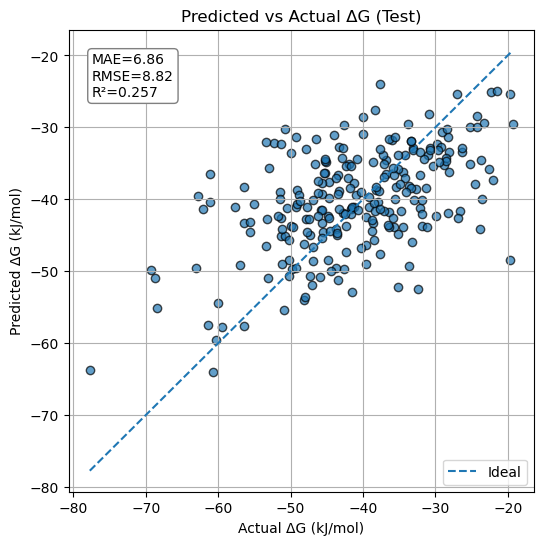

In [40]:
# Evaluate on test set in z-space then invert to kJ/mol
te_mse_z, y_te_z, yhat_te_z = run_epoch(model, test_loader, optimizer=None)
# invert
y_te_pred = yhat_te_z * sd_y + mu_y
y_te_true = y_te_s * sd_y + mu_y

# Metrics in original units
with torch.no_grad():
    y_true_t = torch.tensor(y_te_true).reshape(-1,1)
    y_pred_t = torch.tensor(y_te_pred).reshape(-1,1)
    te = compute_metrics(y_true_t, y_pred_t)
print(f"Test | MSE {te['MSE']:.4f} MAE {te['MAE']:.3f} RMSE {te['RMSE']:.3f} R2 {te['R2']:.3f}")

# Scatter plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_te_true, y_te_pred, alpha=0.7, edgecolor="k")
mn, mx = float(np.min(y_te_true)), float(np.max(y_te_true))
plt.plot([mn, mx], [mn, mx], linestyle="--", label="Ideal")
plt.xlabel("Actual ΔG (kJ/mol)")
plt.ylabel("Predicted ΔG (kJ/mol)")
plt.title("Predicted vs Actual ΔG (Test)")
txt = f"MAE={te['MAE']:.2f}\nRMSE={te['RMSE']:.2f}\nR²={te['R2']:.3f}"
plt.annotate(txt, xy=(0.05,0.95), xycoords='axes fraction', va='top', ha='left',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))
plt.legend(); plt.grid(True); plt.show()


In [1]:
# 1) Imports & Config

import math, random, re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor

# ---- PATHS (EDIT) ----
CSV_A   = "/home/op98/protein_design/dataset/PP/biochemical/dd_partnerA_biophysics_v2020.csv"   # columns: ID + feature_1..feature_94
CSV_B   = "/home/op98/protein_design/dataset/PP/biochemical/dd_partnerB_biophysics_v2020.csv"   # columns: ID + feature_1..feature_94
TARGETS = "/home/op98/protein_design/topology/mGLI-PP/src/data/data_files/binding_affinity_two_proteins.tsv"           # columns like: PDB_ID, ΔG_kJ/mol, Avg_Bfactor_*

OUT_DIR = "./runs/dg_simple_best"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---- SETTINGS ----
SEED       = 42
VAL_SPLIT  = 0.15
TEST_SPLIT = 0.15
CLIP_Q     = (0.001, 0.999)   # robust feature clipping
USE_BFACT  = True             # add Avg_Bfactor_Total / Avg_Bfactor_Interface if present

random.seed(SEED); np.random.seed(SEED)


In [2]:
# 2) Utilities

FEATURE_COLS = [f"feature_{i}" for i in range(1, 95)]

def normalize_pdb_id(x: str) -> str:
    s = str(x).strip().lower()
    m = re.search(r'([0-9a-z]{4})', s)
    return m.group(1) if m else s

def detect_id_col(cols):
    for k in ("ID", "pdb_id", "complex_id", "id"):
        if k in cols: return k
    raise ValueError(f"No ID column detected among: {cols}")

def load_feature_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep=None, engine="python")
    df.columns = [c.strip() for c in df.columns]
    idc = detect_id_col(df.columns)
    missing = [c for c in FEATURE_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"{path} missing features (e.g. {missing[:5]})")
    df = df[[idc] + FEATURE_COLS].copy()
    for c in FEATURE_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["JOIN_ID"] = df[idc].apply(normalize_pdb_id)
    # average duplicates per normalized ID
    df = df.groupby("JOIN_ID", as_index=True)[FEATURE_COLS].mean(numeric_only=True)
    return df.sort_index()

def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mse = np.mean((y_pred - y_true)**2)
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = math.sqrt(mse)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    ss_res = np.sum((y_true - y_pred)**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")
    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2}


In [3]:
# 3) Load & align data

df_a = load_feature_csv(CSV_A)
df_b = load_feature_csv(CSV_B)

df_t = pd.read_csv(TARGETS, sep=None, engine="python")
df_t.columns = [c.strip() for c in df_t.columns]
# standardize headings
if "PDB_ID" in df_t.columns: df_t = df_t.rename(columns={"PDB_ID": "pdb_id"})
if "ΔG_kJ/mol" in df_t.columns: df_t = df_t.rename(columns={"ΔG_kJ/mol": "delta_G"})

need = ["pdb_id", "delta_G"]
for c in need:
    if c not in df_t.columns: raise ValueError(f"targets must contain '{c}'")

extra_cols = []
if USE_BFACT:
    for c in ["Avg_Bfactor_Total", "Avg_Bfactor_Interface"]:
        if c in df_t.columns: extra_cols.append(c)

df_t["JOIN_ID"] = df_t["pdb_id"].apply(normalize_pdb_id)

# keep only IDs present in both A and B
common = set(df_a.index) & set(df_b.index) & set(df_t["JOIN_ID"])
dropped = len(df_t) - sum(df_t["JOIN_ID"].isin(common))
if dropped:
    print(f"[INFO] Dropping {dropped} target rows not present in A & B.")
df_t = df_t[df_t["JOIN_ID"].isin(common)].reset_index(drop=True)

print("A:", df_a.shape, "B:", df_b.shape, "Targets:", df_t.shape, "Common:", len(common))
df_t.head()


[INFO] Dropping 209 target rows not present in A & B.
A: (2570, 94) B: (2570, 94) Targets: (1622, 5) Common: 1622


,pdb_id,delta_G,Avg_Bfactor_Total,Avg_Bfactor_Interface,JOIN_ID
0,1fc2,-43.65,28.67,30.90,1fc2
1,3sgb,-61.34,14.02,10.53,3sgb
2,2tgp,-32.08,17.10,15.16,2tgp
3,2ptc,-75.47,24.28,20.35,2ptc
4,2sni,-66.77,12.83,10.02,2sni


In [4]:
# 4) Features + split

# base matrices aligned to df_t
A_all = df_a.loc[df_t["JOIN_ID"], FEATURE_COLS].to_numpy(dtype=np.float64)
B_all = df_b.loc[df_t["JOIN_ID"], FEATURE_COLS].to_numpy(dtype=np.float64)
y_all = df_t["delta_G"].to_numpy(dtype=np.float64).reshape(-1, 1)

# engineered interactions
SUM   = A_all + B_all
DIFF  = A_all - B_all
ADIFF = np.abs(DIFF)
PROD  = A_all * B_all
COS   = ((A_all * B_all).sum(axis=1) /
         (np.linalg.norm(A_all, axis=1) * np.linalg.norm(B_all, axis=1) + 1e-8)).reshape(-1,1)

parts = [A_all, B_all, SUM, DIFF, ADIFF, PROD, COS]

if extra_cols:
    EX = df_t[extra_cols].to_numpy(dtype=np.float64)
    parts.append(EX)

X_all = np.hstack(parts)

# split indices
idx = list(range(len(df_t))); random.shuffle(idx)
n = len(idx); n_test = int(n*TEST_SPLIT); n_val = int(n*VAL_SPLIT)
test_idx = idx[:n_test]; val_idx = idx[n_test:n_test+n_val]; train_idx = idx[n_test+n_val:]

X_tr, y_tr = X_all[train_idx], y_all[train_idx].ravel()
X_va, y_va = X_all[val_idx],   y_all[val_idx].ravel()
X_te, y_te = X_all[test_idx],  y_all[test_idx].ravel()

# robust clipping (no standardization; trees handle scales fine)
if CLIP_Q is not None:
    lo_tr, hi_tr = np.nanquantile(X_tr, CLIP_Q, axis=0)
    def clip(X): return np.clip(X, lo_tr, hi_tr)
    X_tr, X_va, X_te = clip(X_tr), clip(X_va), clip(X_te)

X_tr.shape, X_va.shape, X_te.shape, y_tr.shape


((1136, 567), (243, 567), (243, 567), (1136,))

In [5]:
# 5) HGB train/tune -> test

param_grid = [
    # (learning_rate, l2_regularization, max_leaf_nodes, min_samples_leaf)
    (0.05, 1e-2, 63, 20),
    (0.03, 1e-2, 63, 20),
    (0.03, 1e-1, 63, 20),
    (0.02, 1e-2, 127, 20),
    (0.03, 1e-3, 127, 10),
]

best = (float("inf"), None)  # (val_mse, model)

for lr, l2, mln, msl in param_grid:
    hgb = HistGradientBoostingRegressor(
        learning_rate=lr, l2_regularization=l2,
        max_leaf_nodes=mln, min_samples_leaf=msl,
        max_iter=1500, early_stopping=True, validation_fraction=0.15,
        random_state=SEED, max_bins=255
    )
    hgb.fit(X_tr, y_tr)
    pred_va = hgb.predict(X_va)
    val_mse = np.mean((pred_va - y_va)**2)
    if val_mse < best[0]:
        best = (val_mse, (lr, l2, mln, msl))

print(f"[HGB] Best on VAL MSE={best[0]:.4f} with params={best[1]}")

# Refit best on TRAIN+VAL, evaluate on TEST
X_trv = np.vstack([X_tr, X_va]); y_trv = np.hstack([y_tr, y_va])
lr, l2, mln, msl = best[1]
hgb_best = HistGradientBoostingRegressor(
    learning_rate=lr, l2_regularization=l2,
    max_leaf_nodes=mln, min_samples_leaf=msl,
    max_iter=1500, early_stopping=False, random_state=SEED, max_bins=255
).fit(X_trv, y_trv)

pred_te = hgb_best.predict(X_te)
metrics = compute_metrics(y_te, pred_te)
print(f"[HGB*] Test | MSE {metrics['MSE']:.4f} MAE {metrics['MAE']:.3f} "
      f"RMSE {metrics['RMSE']:.3f} R2 {metrics['R2']:.3f}")


[HGB] Best on VAL MSE=92.6114 with params=(0.05, 0.01, 63, 20)
[HGB*] Test | MSE 59.9902 MAE 6.191 RMSE 7.745 R2 0.427


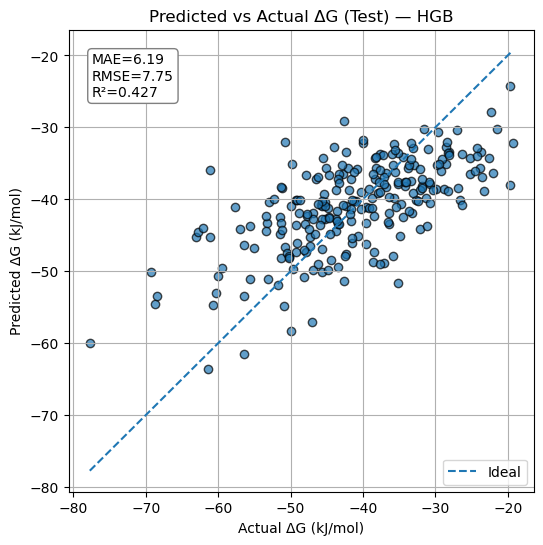

In [7]:
# 6) Plots

plt.figure(figsize=(6,6))
plt.scatter(y_te, pred_te, alpha=0.7, edgecolor="k")
mn, mx = float(np.min(y_te)), float(np.max(y_te))
plt.plot([mn, mx], [mn, mx], linestyle="--", label="Ideal")
plt.xlabel("Actual ΔG (kJ/mol)")
plt.ylabel("Predicted ΔG (kJ/mol)")
plt.title("Predicted vs Actual ΔG (Test) — HGB")
txt = f"MAE={metrics['MAE']:.2f}\nRMSE={metrics['RMSE']:.2f}\nR²={metrics['R2']:.3f}"
plt.annotate(txt, xy=(0.05,0.95), xycoords='axes fraction', va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'))
plt.legend(); plt.grid(True); plt.show()





In [9]:
# 1) Imports & Config

import math, random, re, os
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt

# ---- PATHS (EDIT THESE) ----
CSV_A   = "/home/op98/protein_design/dataset/PP/biochemical/dd_partnerA_biophysics_v2020.csv"   # columns: ID + feature_1..feature_94
CSV_B   = "/home/op98/protein_design/dataset/PP/biochemical/dd_partnerB_biophysics_v2020.csv"   # columns: ID + feature_1..feature_94
TARGETS = "/home/op98/protein_design/topology/mGLI-PP/src/data/data_files/binding_affinity_two_proteins.tsv"           # columns like: PDB_ID, ΔG_kJ/mol, Avg_Bfactor_*
MGLI_PT_DIR  = "/home/op98/protein_design/topology/mGLI-PP/src/data/data_files/pt"

OUT_DIR = "./runs/dg_mlp_with_mgli"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---- SETTINGS ----
SEED         = 42
VAL_SPLIT    = 0.15
TEST_SPLIT   = 0.15
USE_BFACTORS = True               # include Avg_Bfactor_* cols if present
CLIP_Q_TAB   = (0.001, 0.999)     # quantile clip for tabular features
CLIP_Q_MGLI  = (0.001, 0.999)     # quantile clip for mGLI features
MGLI_EXPECTED_DIM = 1440          # from generation code (4x4 el pairs * 9 intervals * (5 stats * 2 directions))

BATCH_SIZE   = 64
LR           = 3e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 300
PATIENCE     = 30

device = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print("Device:", device)


Device: cpu


In [10]:
# 2) Utilities

FEATURE_COLS = [f"feature_{i}" for i in range(1, 95)]

def normalize_pdb_id(x: str) -> str:
    """Normalize to 4-char PDB code (lowercase), robust to extras (chains, spaces, etc.)."""
    s = str(x).strip().lower()
    m = re.search(r'([0-9a-z]{4})', s)
    return m.group(1) if m else s

def detect_id_col(cols: List[str]) -> str:
    for k in ("ID", "pdb_id", "complex_id", "id"):
        if k in cols: return k
    raise ValueError(f"No ID column detected among: {cols[:8]} ...")

def load_feature_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep=None, engine="python")
    df.columns = [c.strip() for c in df.columns]
    idc = detect_id_col(df.columns)
    missing = [c for c in FEATURE_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"{path} missing features (e.g. {missing[:5]})")
    df = df[[idc] + FEATURE_COLS].copy()
    for c in FEATURE_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["JOIN_ID"] = df[idc].apply(normalize_pdb_id)
    # average duplicates per normalized ID
    df = df.groupby("JOIN_ID", as_index=True)[FEATURE_COLS].mean(numeric_only=True)
    return df.sort_index()

def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mse = np.mean((y_pred - y_true)**2)
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = math.sqrt(mse)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    ss_res = np.sum((y_true - y_pred)**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")
    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2}

def fit_scaler(X: np.ndarray, clip_q: Optional[Tuple[float,float]] = None):
    X64 = X.astype(np.float64, copy=True)
    if clip_q is not None:
        lo, hi = np.nanquantile(X64, clip_q, axis=0)
        X64 = np.clip(X64, lo, hi)
    else:
        lo = hi = None
    mu = np.nanmean(X64, axis=0)
    sd = np.nanstd(X64, axis=0)
    sd[sd == 0] = 1.0
    return {"mu": mu, "sd": sd, "clip_lo": lo, "clip_hi": hi}

def apply_scaler(X: np.ndarray, sc: Dict[str, np.ndarray]):
    X64 = X.astype(np.float64, copy=True)
    if sc["clip_lo"] is not None:
        X64 = np.clip(X64, sc["clip_lo"], sc["clip_hi"])
    return (X64 - sc["mu"]) / sc["sd"]


In [11]:
# 3) Load & align data

df_a = load_feature_csv(CSV_A)
df_b = load_feature_csv(CSV_B)

df_t = pd.read_csv(TARGETS, sep=None, engine="python")
df_t.columns = [c.strip() for c in df_t.columns]
# header normalization
if "PDB_ID" in df_t.columns: df_t = df_t.rename(columns={"PDB_ID": "pdb_id"})
if "ΔG_kJ/mol" in df_t.columns: df_t = df_t.rename(columns={"ΔG_kJ/mol": "delta_G"})
if "deltaG" in df_t.columns: df_t = df_t.rename(columns={"deltaG": "delta_G"})

for col in ("pdb_id", "delta_G"):
    if col not in df_t.columns:
        raise ValueError(f"targets must contain '{col}'")

# optional extra input features from targets
extra_cols = []
if USE_BFACTORS:
    for c in ["Avg_Bfactor_Total", "Avg_Bfactor_Interface"]:
        if c in df_t.columns: extra_cols.append(c)

df_t["JOIN_ID"] = df_t["pdb_id"].apply(normalize_pdb_id)

# keep only IDs present in both A and B
common = set(df_a.index) & set(df_b.index) & set(df_t["JOIN_ID"])
dropped = len(df_t) - sum(df_t["JOIN_ID"].isin(common))
if dropped:
    print(f"[INFO] Dropping {dropped} target rows not present in A & B.")
df_t = df_t[df_t["JOIN_ID"].isin(common)].reset_index(drop=True)

print("A:", df_a.shape, "B:", df_b.shape, "Targets:", df_t.shape, "Common:", len(common))


[INFO] Dropping 209 target rows not present in A & B.
A: (2570, 94) B: (2570, 94) Targets: (1622, 5) Common: 1622


In [12]:
# 4) Biochemical features (A, B, SUM, DIFF, |DIFF|, PROD, COS, optional B-factors)

A_all = df_a.loc[df_t["JOIN_ID"], FEATURE_COLS].to_numpy(dtype=np.float64)
B_all = df_b.loc[df_t["JOIN_ID"], FEATURE_COLS].to_numpy(dtype=np.float64)
y_all = df_t["delta_G"].to_numpy(dtype=np.float64).reshape(-1, 1)

SUM   = A_all + B_all
DIFF  = A_all - B_all
ADIFF = np.abs(DIFF)
PROD  = A_all * B_all
COS   = ((A_all * B_all).sum(axis=1) /
         (np.linalg.norm(A_all, axis=1) * np.linalg.norm(B_all, axis=1) + 1e-8)).reshape(-1,1)

parts = [A_all, B_all, SUM, DIFF, ADIFF, PROD, COS]
if extra_cols:
    EX = df_t[extra_cols].to_numpy(dtype=np.float64)
    parts.append(EX)

X_tab_all = np.hstack(parts)
X_tab_all.shape


(1622, 567)

In [13]:
# 5) mGLI features loader (expects files like '<pdb>_mGLI.pt' in MGLI_PT_DIR)

def load_mgli_vector(pdb_id: str, pt_dir: str, expected_dim: int = MGLI_EXPECTED_DIM) -> np.ndarray:
    """
    Load 1D tensor from '<pdb>_mGLI.pt'. If missing, return zeros.
    If length differs, pad/crop to expected_dim.
    """
    path = os.path.join(pt_dir, f"{pdb_id}_mGLI.pt")
    if not os.path.exists(path):
        return np.zeros((expected_dim,), dtype=np.float32)
    t = torch.load(path, map_location="cpu")
    v = t.view(-1).to(torch.float32).numpy()
    if v.size < expected_dim:
        v = np.pad(v, (0, expected_dim - v.size))
    elif v.size > expected_dim:
        v = v[:expected_dim]
    return v.astype(np.float32)

# Build X_mgli matrix aligned to df_t rows
X_mgli_all = np.stack([load_mgli_vector(pid, MGLI_PT_DIR, MGLI_EXPECTED_DIM)
                       for pid in df_t["JOIN_ID"]], axis=0).astype(np.float64)

print("mGLI shape:", X_mgli_all.shape)  # (N, 1440) expected


/tmp/ipykernel_453570/499713645.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load(path, map_location="cpu")


mGLI shape: (1622, 1440)


In [15]:
# 6) Split + scalers

idx = list(range(len(df_t))); random.shuffle(idx)
n = len(idx); n_test = int(n * TEST_SPLIT); n_val = int(n * VAL_SPLIT)
test_idx = idx[:n_test]; val_idx = idx[n_test:n_test+n_val]; train_idx = idx[n_test+n_val:]

Xtab_tr, Xtab_va, Xtab_te = X_tab_all[train_idx], X_tab_all[val_idx], X_tab_all[test_idx]
Xgli_tr, Xgli_va, Xgli_te = X_mgli_all[train_idx], X_mgli_all[val_idx], X_mgli_all[test_idx]
y_tr, y_va, y_te = y_all[train_idx], y_all[val_idx], y_all[test_idx]

# Fit separate scalers (train-only), with quantile clipping
sc_tab  = fit_scaler(Xtab_tr, clip_q=CLIP_Q_TAB)
sc_mgli = fit_scaler(Xgli_tr, clip_q=CLIP_Q_MGLI)

Xtab_tr_s = apply_scaler(Xtab_tr, sc_tab)
Xtab_va_s = apply_scaler(Xtab_va, sc_tab)
Xtab_te_s = apply_scaler(Xtab_te, sc_tab)

Xgli_tr_s = apply_scaler(Xgli_tr, sc_mgli)
Xgli_va_s = apply_scaler(Xgli_va, sc_mgli)
Xgli_te_s = apply_scaler(Xgli_te, sc_mgli)

# Concatenate scaled blocks -> final NN inputs
X_tr = np.hstack([Xtab_tr_s, Xgli_tr_s]).astype(np.float32)
X_va = np.hstack([Xtab_va_s, Xgli_va_s]).astype(np.float32)
X_te = np.hstack([Xtab_te_s, Xgli_te_s]).astype(np.float32)

# (Optional) standardize target to stabilize training
mu_y, sd_y = y_tr.mean(), y_tr.std() if y_tr.std() > 0 else 1.0
y_tr_s = ((y_tr - mu_y) / sd_y).astype(np.float32)
y_va_s = ((y_va - mu_y) / sd_y).astype(np.float32)
y_te_s = ((y_te - mu_y) / sd_y).astype(np.float32)

X_tr.shape, X_va.shape, X_te.shape, y_tr_s.shape


((1136, 2007), (243, 2007), (243, 2007), (1136, 1))

In [16]:
# 7) DataLoaders

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr_s)),
                          batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va_s)),
                          batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te_s)),
                          batch_size=BATCH_SIZE, shuffle=False)


In [17]:
# 8) Model

class BetterMLP(nn.Module):
    def __init__(self, in_dim: int, widths=(1024, 512, 256), p=0.25):
        super().__init__()
        layers = []
        prev = in_dim
        for w in widths:
            layers += [nn.Linear(prev, w), nn.BatchNorm1d(w), nn.GELU(), nn.Dropout(p)]
            prev = w
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = BetterMLP(in_dim=X_tr.shape[1], widths=(1024, 512, 256), p=0.25).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=6, verbose=True)


/home/op98/.conda/envs/protein_design/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
# 9) Train

def run_epoch(model, loader, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()
    total, n = 0.0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = model(xb)
            loss = nn.functional.mse_loss(pred, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            bsz = xb.size(0); total += loss.item() * bsz; n += bsz
    return total / max(n,1)

best_val, best_state, wait = float("inf"), None, 0
for epoch in range(1, EPOCHS + 1):
    tr = run_epoch(model, train_loader, optimizer=opt)
    va = run_epoch(model, val_loader,   optimizer=None)
    scheduler.step(va)
    print(f"Epoch {epoch:03d} | Train MSE(z) {tr:.4f} | Val MSE(z) {va:.4f}")
    if va + 1e-8 < best_val:
        best_val, best_state, wait = va, model.state_dict(), 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stop at epoch {epoch} (best Val MSE(z) {best_val:.4f})")
            break

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 001 | Train MSE(z) 1.1033 | Val MSE(z) 1.0074
Epoch 002 | Train MSE(z) 0.7449 | Val MSE(z) 0.8972
Epoch 003 | Train MSE(z) 0.6745 | Val MSE(z) 0.9016
Epoch 004 | Train MSE(z) 0.6325 | Val MSE(z) 0.8557
Epoch 005 | Train MSE(z) 0.5638 | Val MSE(z) 0.8455
Epoch 006 | Train MSE(z) 0.4939 | Val MSE(z) 0.8104
Epoch 007 | Train MSE(z) 0.4937 | Val MSE(z) 0.7936
Epoch 008 | Train MSE(z) 0.4714 | Val MSE(z) 0.8173
Epoch 009 | Train MSE(z) 0.4748 | Val MSE(z) 0.8673
Epoch 010 | Train MSE(z) 0.4101 | Val MSE(z) 0.7984
Epoch 011 | Train MSE(z) 0.3666 | Val MSE(z) 0.9367
Epoch 012 | Train MSE(z) 0.3807 | Val MSE(z) 0.8904
Epoch 013 | Train MSE(z) 0.3333 | Val MSE(z) 0.8080
Epoch 014 | Train MSE(z) 0.3306 | Val MSE(z) 0.8328
Epoch 015 | Train MSE(z) 0.2956 | Val MSE(z) 0.8227
Epoch 016 | Train MSE(z) 0.2840 | Val MSE(z) 0.8131
Epoch 017 | Train MSE(z) 0.2510 | Val MSE(z) 0.8430
Epoch 018 | Train MSE(z) 0.2278 | Val MSE(z) 0.8852
Epoch 019 | Train MSE(z) 0.2327 | Val MSE(z) 0.8729
Epoch 020 | 

[NN+mGLI] Test | MSE 110.8062 MAE 8.156 RMSE 10.526 R2 0.139


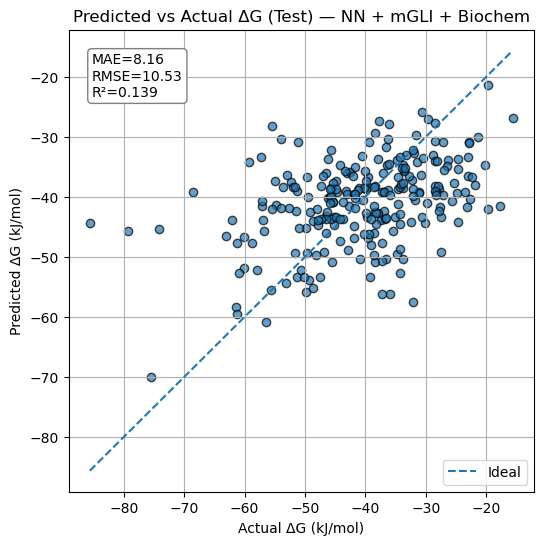

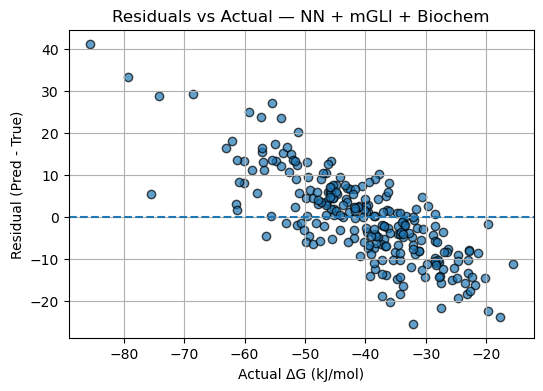

In [19]:
# 10) Evaluate + Plots

# Collect predictions on test in z-space
model.eval()
with torch.no_grad():
    preds = []
    for xb, _ in test_loader:
        xb = xb.to(device)
        p = model(xb).cpu().numpy().ravel()
        preds.append(p)
    yhat_te_z = np.concatenate(preds, axis=0)

# invert to original units
y_te_true = y_te_s.ravel() * sd_y + mu_y
y_te_pred = yhat_te_z * sd_y + mu_y

metrics = compute_metrics(y_te_true, y_te_pred)
print(f"[NN+mGLI] Test | MSE {metrics['MSE']:.4f} MAE {metrics['MAE']:.3f} "
      f"RMSE {metrics['RMSE']:.3f} R2 {metrics['R2']:.3f}")

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_te_true, y_te_pred, alpha=0.7, edgecolor="k")
mn, mx = float(np.min(y_te_true)), float(np.max(y_te_true))
plt.plot([mn, mx], [mn, mx], linestyle="--", label="Ideal")
plt.xlabel("Actual ΔG (kJ/mol)"); plt.ylabel("Predicted ΔG (kJ/mol)")
plt.title("Predicted vs Actual ΔG (Test) — NN + mGLI + Biochem")
txt = f"MAE={metrics['MAE']:.2f}\nRMSE={metrics['RMSE']:.2f}\nR²={metrics['R2']:.3f}"
plt.annotate(txt, xy=(0.05,0.95), xycoords='axes fraction', va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'))
plt.legend(); plt.grid(True); plt.show()

# Residuals
res = y_te_pred - y_te_true
plt.figure(figsize=(6,4))
plt.scatter(y_te_true, res, alpha=0.7, edgecolor="k")
plt.axhline(0, linestyle="--")
plt.xlabel("Actual ΔG (kJ/mol)")
plt.ylabel("Residual (Pred - True)")
plt.title("Residuals vs Actual — NN + mGLI + Biochem")
plt.grid(True); plt.show()


In [20]:
# A) mGLI coverage & sanity checks
import os, numpy as np

mgli_paths = [os.path.join(MGLI_PT_DIR, f"{pid}_mGLI.pt") for pid in df_t["JOIN_ID"]]
exists = np.array([os.path.exists(p) for p in mgli_paths])
print(f"mGLI coverage: {exists.mean()*100:.1f}%  ({exists.sum()}/{len(exists)})")

# How many vectors are all-zeros? (after loading)
def load_vec(p):
    if not os.path.exists(p): return np.zeros((MGLI_EXPECTED_DIM,), dtype=np.float32)
    v = torch.load(p, map_location="cpu").view(-1).to(torch.float32).numpy()
    if v.size < MGLI_EXPECTED_DIM: v = np.pad(v, (0, MGLI_EXPECTED_DIM - v.size))
    elif v.size > MGLI_EXPECTED_DIM: v = v[:MGLI_EXPECTED_DIM]
    return v

sample = np.stack([load_vec(p) for p in mgli_paths[:min(200, len(mgli_paths))]], axis=0)
zero_like = (np.abs(sample).sum(axis=1) == 0).mean()*100
print(f"Among first {len(sample)} mGLI vectors, ~{zero_like:.1f}% are all-zeros")


mGLI coverage: 92.0%  (1492/1622)
Among first 200 mGLI vectors, ~10.0% are all-zeros


/tmp/ipykernel_453570/1790498447.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  v = torch.load(p, map_location="cpu").view(-1).to(torch.float32).numpy()


In [21]:
# 1) Imports & Config

import math, random, re, os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor

# ---- PATHS (EDIT) ----
CSV_A   = "/home/op98/protein_design/dataset/PP/biochemical/dd_partnerA_biophysics_v2020.csv"   # columns: ID + feature_1..feature_94
CSV_B   = "/home/op98/protein_design/dataset/PP/biochemical/dd_partnerB_biophysics_v2020.csv"   # columns: ID + feature_1..feature_94
TARGETS = "/home/op98/protein_design/topology/mGLI-PP/src/data/data_files/binding_affinity_two_proteins.tsv"           # columns like: PDB_ID, ΔG_kJ/mol, Avg_Bfactor_*
MGLI_PT_DIR  = "/home/op98/protein_design/topology/mGLI-PP/src/data/data_files/pt"

OUT_DIR = "./runs/dg_hgb_tab_mgli_fixed"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---- SETTINGS ----
SEED       = 42
VAL_SPLIT  = 0.15
TEST_SPLIT = 0.15
USE_BFACT  = True                   # include Avg_Bfactor_Total / Avg_Bfactor_Interface if present
CLIP_Q_TAB = (0.001, 0.999)         # tabular robust clip
CLIP_Q_MGLI= (0.001, 0.999)         # mGLI robust clip
MGLI_EXPECTED_DIM = 1440            # generator yields ~1440 dims

random.seed(SEED); np.random.seed(SEED)
print("Configured. Edit paths at top if needed.")


Configured. Edit paths at top if needed.


In [22]:
# 2) Utilities

FEATURE_COLS = [f"feature_{i}" for i in range(1, 95)]

def normalize_pdb_id(x: str) -> str:
    s = str(x).strip().lower()
    m = re.search(r'([0-9a-z]{4})', s)
    return m.group(1) if m else s

def detect_id_col(cols):
    for k in ("ID", "pdb_id", "complex_id", "id"):
        if k in cols: return k
    raise ValueError(f"No ID column among: {cols}")

def load_feature_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep=None, engine="python")
    df.columns = [c.strip() for c in df.columns]
    idc = detect_id_col(df.columns)
    missing = [c for c in FEATURE_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"{path} missing features (e.g. {missing[:5]})")
    df = df[[idc] + FEATURE_COLS].copy()
    for c in FEATURE_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["JOIN_ID"] = df[idc].apply(normalize_pdb_id)
    df = df.groupby("JOIN_ID", as_index=True)[FEATURE_COLS].mean(numeric_only=True)
    return df.sort_index()

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mse = np.mean((y_pred - y_true)**2)
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = math.sqrt(mse)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    ss_res = np.sum((y_true - y_pred)**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")
    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2}


In [23]:
# 3) Load & Align

df_a = load_feature_csv(CSV_A)
df_b = load_feature_csv(CSV_B)

df_t = pd.read_csv(TARGETS, sep=None, engine="python")
df_t.columns = [c.strip() for c in df_t.columns]
if "PDB_ID" in df_t.columns: df_t = df_t.rename(columns={"PDB_ID": "pdb_id"})
if "ΔG_kJ/mol" in df_t.columns: df_t = df_t.rename(columns={"ΔG_kJ/mol": "delta_G"})
if "deltaG" in df_t.columns: df_t = df_t.rename(columns={"deltaG": "delta_G"})
for c in ("pdb_id", "delta_G"):
    if c not in df_t.columns: raise ValueError(f"targets must contain '{c}'")

extra_cols = []
if USE_BFACT:
    for c in ("Avg_Bfactor_Total", "Avg_Bfactor_Interface"):
        if c in df_t.columns: extra_cols.append(c)

df_t["JOIN_ID"] = df_t["pdb_id"].apply(normalize_pdb_id)

common = set(df_a.index) & set(df_b.index) & set(df_t["JOIN_ID"])
dropped = len(df_t) - sum(df_t["JOIN_ID"].isin(common))
if dropped: print(f"[INFO] Dropping {dropped} target rows not present in A & B.")
df_t = df_t[df_t["JOIN_ID"].isin(common)].reset_index(drop=True)

print("A:", df_a.shape, "B:", df_b.shape, "Targets:", df_t.shape, "Common:", len(common))


[INFO] Dropping 209 target rows not present in A & B.
A: (2570, 94) B: (2570, 94) Targets: (1622, 5) Common: 1622


In [24]:
# 4) Tabular features

A_all = df_a.loc[df_t["JOIN_ID"], FEATURE_COLS].to_numpy(dtype=np.float64)
B_all = df_b.loc[df_t["JOIN_ID"], FEATURE_COLS].to_numpy(dtype=np.float64)
y_all = df_t["delta_G"].to_numpy(dtype=np.float64)

SUM   = A_all + B_all
DIFF  = A_all - B_all
ADIFF = np.abs(DIFF)
PROD  = A_all * B_all
COS   = ((A_all * B_all).sum(axis=1) /
         (np.linalg.norm(A_all, axis=1) * np.linalg.norm(B_all, axis=1) + 1e-8)).reshape(-1,1)

parts = [A_all, B_all, SUM, DIFF, ADIFF, PROD, COS]
if extra_cols:
    EX = df_t[extra_cols].to_numpy(dtype=np.float64)
    parts.append(EX)

X_tab_all = np.hstack(parts)
print("Tabular shape:", X_tab_all.shape)


Tabular shape: (1622, 567)


In [25]:
# 5) mGLI load + mask + TRAIN-only clip & PCA on non-zero

def load_mgli_vector(pid: str, pt_dir: str, expected_dim: int) -> np.ndarray:
    path = os.path.join(pt_dir, f"{pid}_mGLI.pt")
    if not os.path.exists(path):
        return np.zeros((expected_dim,), dtype=np.float32)
    v = np.asarray(torch.load(path, map_location="cpu").view(-1), dtype=np.float32)
    if v.size < expected_dim: v = np.pad(v, (0, expected_dim - v.size))
    elif v.size > expected_dim: v = v[:expected_dim]
    return v

# Build mGLI matrix aligned to df_t
X_mgli_all = np.stack([load_mgli_vector(pid, MGLI_PT_DIR, MGLI_EXPECTED_DIM)
                       for pid in df_t["JOIN_ID"]], axis=0).astype(np.float64)

# Coverage diagnostics
exists = np.array([os.path.exists(os.path.join(MGLI_PT_DIR, f"{pid}_mGLI.pt"))
                   for pid in df_t["JOIN_ID"]])
mask_nonzero = (np.abs(X_mgli_all).sum(axis=1) > 1e-6).astype(np.float32)
print(f"mGLI coverage: {exists.mean()*100:.1f}% | non-zero vectors: {mask_nonzero.mean()*100:.1f}%")

# Split indices ONCE (and reuse everywhere)
idx = list(range(len(df_t))); random.shuffle(idx)
n = len(idx); n_test = int(n*TEST_SPLIT); n_val = int(n*VAL_SPLIT)
test_idx = idx[:n_test]; val_idx = idx[n_test:n_test+n_val]; train_idx = idx[n_test+n_val:]

# TRAIN-only transform pipeline for mGLI:
# 1) take train subset
Xm_tr_raw = X_mgli_all[train_idx]
mask_tr_nonzero = (np.abs(Xm_tr_raw).sum(axis=1) > 1e-6)

# 2) fit clip on non-zero only
Xm_tr_nz = Xm_tr_raw[mask_tr_nonzero]
Xm_tr_nz = np.log1p(Xm_tr_nz)
lo_m, hi_m = np.nanquantile(Xm_tr_nz, CLIP_Q_MGLI, axis=0)
Xm_tr_nz_c = np.clip(Xm_tr_nz, lo_m, hi_m)

# 3) PCA on TRAIN NON-ZERO
MGLI_PCA_K = 32
pca_mgli = PCA(n_components=MGLI_PCA_K, random_state=SEED).fit(Xm_tr_nz_c)

# 4) Apply to ALL splits:
def transform_mgli_block(X_raw):
    X = np.log1p(X_raw)
    X = np.clip(X, lo_m, hi_m)
    Z = pca_mgli.transform(X)      # PCA can handle zero-like via learned components
    mask = (np.abs(X_raw).sum(axis=1) > 1e-6).astype(np.float32).reshape(-1,1)
    return np.hstack([Z, mask])

Xm_tr_blk = transform_mgli_block(X_mgli_all[train_idx])
Xm_va_blk = transform_mgli_block(X_mgli_all[val_idx])
Xm_te_blk = transform_mgli_block(X_mgli_all[test_idx])

print("mGLI block shapes:", Xm_tr_blk.shape, Xm_va_blk.shape, Xm_te_blk.shape)


/tmp/ipykernel_453570/1626292045.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  v = np.asarray(torch.load(path, map_location="cpu").view(-1), dtype=np.float32)


mGLI coverage: 92.0% | non-zero vectors: 91.9%
mGLI block shapes: (1136, 33) (243, 33) (243, 33)


In [26]:
# 6) Tabular clip (TRAIN-only), then fuse with mGLI block

Xtab_tr, Xtab_va, Xtab_te = X_tab_all[train_idx], X_tab_all[val_idx], X_tab_all[test_idx]
y_tr,    y_va,    y_te    = y_all[train_idx],     y_all[val_idx],     y_all[test_idx]

lo_t, hi_t = np.nanquantile(Xtab_tr, CLIP_Q_TAB, axis=0)
def clip(X): return np.clip(X, lo_t, hi_t)

Xtab_tr_c = clip(Xtab_tr); Xtab_va_c = clip(Xtab_va); Xtab_te_c = clip(Xtab_te)

# Final design matrices
X_tr = np.hstack([Xtab_tr_c, Xm_tr_blk])
X_va = np.hstack([Xtab_va_c, Xm_va_blk])
X_te = np.hstack([Xtab_te_c, Xm_te_blk])

print("Final shapes:", X_tr.shape, X_va.shape, X_te.shape)


Final shapes: (1136, 600) (243, 600) (243, 600)


In [27]:
# 7) HGB tune (on VAL), refit on TRAIN+VAL, evaluate once on TEST

param_grid = [
    # (learning_rate, l2_regularization, max_leaf_nodes, min_samples_leaf)
    (0.03, 1e-2, 63, 20),
    (0.03, 1e-1, 63, 20),
    (0.02, 1e-2, 127, 20),
    (0.05, 1e-2, 63, 20),
]

best = (float("inf"), None)
for lr, l2, mln, msl in param_grid:
    hgb = HistGradientBoostingRegressor(
        learning_rate=lr, l2_regularization=l2,
        max_leaf_nodes=mln, min_samples_leaf=msl,
        max_iter=1500, early_stopping=True, validation_fraction=0.15,
        random_state=SEED, max_bins=255
    )
    hgb.fit(X_tr, y_tr)
    mse_va = np.mean((hgb.predict(X_va) - y_va)**2)
    if mse_va < best[0]:
        best = (mse_va, (lr, l2, mln, msl))

print(f"[HGB] best on VAL MSE={best[0]:.4f} params={best[1]}")

# Refit on TRAIN+VAL
X_trv = np.vstack([X_tr, X_va]); y_trv = np.hstack([y_tr, y_va])
lr, l2, mln, msl = best[1]
hgb_best = HistGradientBoostingRegressor(
    learning_rate=lr, l2_regularization=l2,
    max_leaf_nodes=mln, min_samples_leaf=msl,
    max_iter=1500, early_stopping=False, random_state=SEED, max_bins=255
).fit(X_trv, y_trv)

# Test
y_pred = hgb_best.predict(X_te)
m = metrics(y_te, y_pred)
print(f"[HGB + PCA(mGLI)+mask] Test | MSE {m['MSE']:.4f} MAE {m['MAE']:.3f} "
      f"RMSE {m['RMSE']:.3f} R2 {m['R2']:.3f}")


[HGB] best on VAL MSE=89.7103 params=(0.02, 0.01, 127, 20)
[HGB + PCA(mGLI)+mask] Test | MSE 58.4443 MAE 6.043 RMSE 7.645 R2 0.442


In [28]:
# 7) HGB tune (on VAL), refit on TRAIN+VAL, evaluate once on TEST

param_grid = [
    # (learning_rate, l2_regularization, max_leaf_nodes, min_samples_leaf)
    (0.03, 1e-2, 63, 20),
    (0.03, 1e-1, 63, 20),
    (0.02, 1e-2, 127, 20),
    (0.05, 1e-2, 63, 20),
]

best = (float("inf"), None)
for lr, l2, mln, msl in param_grid:
    hgb = HistGradientBoostingRegressor(
        learning_rate=lr, l2_regularization=l2,
        max_leaf_nodes=mln, min_samples_leaf=msl,
        max_iter=1500, early_stopping=True, validation_fraction=0.15,
        random_state=SEED, max_bins=255
    )
    hgb.fit(X_tr, y_tr)
    mse_va = np.mean((hgb.predict(X_va) - y_va)**2)
    if mse_va < best[0]:
        best = (mse_va, (lr, l2, mln, msl))

print(f"[HGB] best on VAL MSE={best[0]:.4f} params={best[1]}")

# Refit on TRAIN+VAL
X_trv = np.vstack([X_tr, X_va]); y_trv = np.hstack([y_tr, y_va])
lr, l2, mln, msl = best[1]
hgb_best = HistGradientBoostingRegressor(
    learning_rate=lr, l2_regularization=l2,
    max_leaf_nodes=mln, min_samples_leaf=msl,
    max_iter=1500, early_stopping=False, random_state=SEED, max_bins=255
).fit(X_trv, y_trv)

# Test
y_pred = hgb_best.predict(X_te)
m = metrics(y_te, y_pred)
print(f"[HGB + PCA(mGLI)+mask] Test | MSE {m['MSE']:.4f} MAE {m['MAE']:.3f} "
      f"RMSE {m['RMSE']:.3f} R2 {m['R2']:.3f}")


[HGB] best on VAL MSE=89.7103 params=(0.02, 0.01, 127, 20)
[HGB + PCA(mGLI)+mask] Test | MSE 58.4443 MAE 6.043 RMSE 7.645 R2 0.442


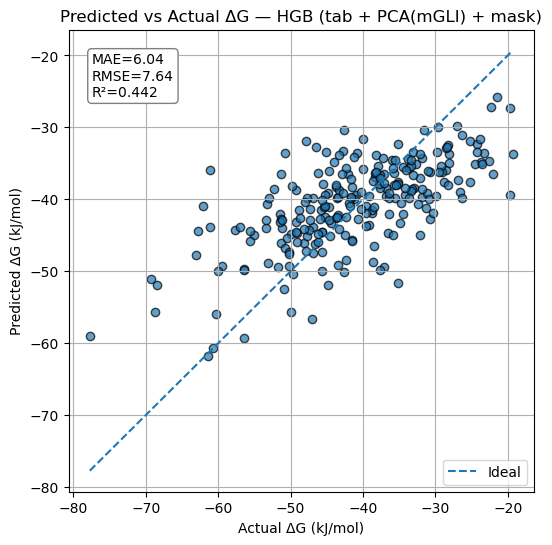

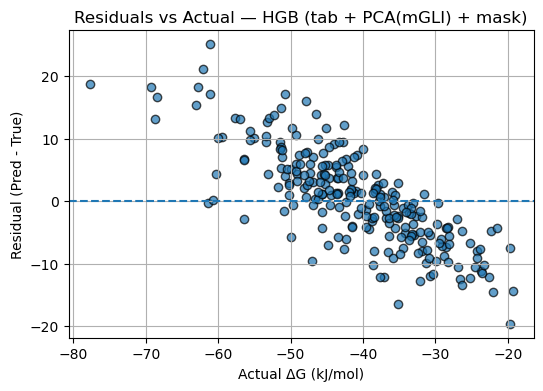

In [29]:
# 8) Plots

plt.figure(figsize=(6,6))
plt.scatter(y_te, y_pred, alpha=0.7, edgecolor="k")
mn, mx = float(np.min(y_te)), float(np.max(y_te))
plt.plot([mn, mx], [mn, mx], linestyle="--", label="Ideal")
plt.xlabel("Actual ΔG (kJ/mol)"); plt.ylabel("Predicted ΔG (kJ/mol)")
plt.title("Predicted vs Actual ΔG — HGB (tab + PCA(mGLI) + mask)")
txt = f"MAE={m['MAE']:.2f}\nRMSE={m['RMSE']:.2f}\nR²={m['R2']:.3f}"
plt.annotate(txt, xy=(0.05,0.95), xycoords='axes fraction', va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'))
plt.legend(); plt.grid(True); plt.show()

res = y_pred - y_te
plt.figure(figsize=(6,4))
plt.scatter(y_te, res, alpha=0.7, edgecolor="k")
plt.axhline(0, linestyle="--")
plt.xlabel("Actual ΔG (kJ/mol)")
plt.ylabel("Residual (Pred - True)")
plt.title("Residuals vs Actual — HGB (tab + PCA(mGLI) + mask)")
plt.grid(True); plt.show()


In [8]:
# Cell 1 — Imports & Config

import os, re, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ======= EDIT THESE =======
TARGETS_TSV = "/home/op98/protein_design/topology/mGLI-PP/src/data/data_files/binding_affinity_two_proteins.tsv"           # columns like: PDB_ID, ΔG_kJ/mol, Avg_Bfactor_*
PT_DIR  = "/home/op98/protein_design/topology/mGLI-PP/src/data/data_files/pt"
# ==========================

SEED        = 42
VAL_SPLIT   = 0.15
TEST_SPLIT  = 0.15
BATCH_SIZE  = 64
LR          = 3e-4
EPOCHS      = 200
PATIENCE    = 20
MGLI_EXPECTED_DIM = 1440   # pad/trim to this
CLIP_Q      = (0.001, 0.999)

device = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print("Device:", device)


Device: cpu


In [9]:
# Cell 2 — Utilities

def normalize_pdb_id(x: str) -> str:
    s = str(x).strip().lower()
    m = re.search(r'([0-9a-z]{4})', s)
    return m.group(1) if m else s

def load_targets(tsv_path: str) -> pd.DataFrame:
    df = pd.read_csv(tsv_path, sep=None, engine="python")
    df.columns = [c.strip() for c in df.columns]
    if "PDB_ID" in df.columns: df = df.rename(columns={"PDB_ID": "pdb_id"})
    if "ΔG_kJ/mol" in df.columns: df = df.rename(columns={"ΔG_kJ/mol": "delta_G"})
    if "deltaG" in df.columns: df = df.rename(columns={"deltaG": "delta_G"})
    df["JOIN_ID"] = df["pdb_id"].apply(normalize_pdb_id)
    return df[["JOIN_ID", "delta_G"]]

def load_mgli(pid: str, pt_dir: str, expected_dim: int) -> np.ndarray | None:
    path = os.path.join(pt_dir, f"{pid}_mGLI.pt")
    if not os.path.exists(path): return None
    v = torch.load(path, map_location="cpu")
    v = np.asarray(np.array(v).reshape(-1), dtype=np.float32)
    if v.size < expected_dim: v = np.pad(v, (0, expected_dim - v.size))
    elif v.size > expected_dim: v = v[:expected_dim]
    return v

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mse = np.mean((y_pred - y_true)**2)
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = math.sqrt(mse)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    ss_res = np.sum((y_true - y_pred)**2)
    r2 = 1 - ss_res/ss_tot if ss_tot>0 else float("nan")
    return {"MSE":mse, "MAE":mae, "RMSE":rmse, "R2":r2}


In [10]:
# Cell 3 — Load data & preprocess

df_t = load_targets(TARGETS_TSV)
pids = df_t["JOIN_ID"].tolist()
y_all = df_t["delta_G"].to_numpy(dtype=np.float32)

X = []
keep_idx = []
for i,p in enumerate(pids):
    v = load_mgli(p, PT_DIR, MGLI_EXPECTED_DIM)
    if v is not None:
        X.append(v); keep_idx.append(i)
X = np.stack(X, axis=0).astype(np.float32)
y = y_all[keep_idx]

print("Loaded:", X.shape, "targets:", y.shape)

# split
idx = np.arange(len(y)); np.random.shuffle(idx)
n = len(idx); n_test=int(n*TEST_SPLIT); n_val=int(n*VAL_SPLIT)
test_idx, val_idx, train_idx = idx[:n_test], idx[n_test:n_test+n_val], idx[n_test+n_val:]

X_tr, X_va, X_te = X[train_idx], X[val_idx], X[test_idx]
y_tr, y_va, y_te = y[train_idx], y[val_idx], y[test_idx]

# log1p + clip (train-only)
X_tr = np.log1p(X_tr); X_va = np.log1p(X_va); X_te = np.log1p(X_te)
lo, hi = np.nanquantile(X_tr, CLIP_Q, axis=0)
def clip(x): return np.clip(x, lo, hi)
X_tr, X_va, X_te = clip(X_tr), clip(X_va), clip(X_te)

# z-score features
mu, sd = X_tr.mean(0), X_tr.std(0); sd[sd==0]=1
def norm(x): return (x-mu)/sd
X_tr, X_va, X_te = norm(X_tr), norm(X_va), norm(X_te)

# z-score target
mu_y, sd_y = y_tr.mean(), (y_tr.std() if y_tr.std()>0 else 1)
y_tr_z = (y_tr-mu_y)/sd_y; y_va_z = (y_va-mu_y)/sd_y; y_te_z = (y_te-mu_y)/sd_y


/tmp/ipykernel_807943/1479408503.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  v = torch.load(path, map_location="cpu")


Loaded: (1492, 1440) targets: (1492,)


In [13]:
# DataLoaders & Model (dtype-safe)

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_tr.astype(np.float32)),
                  torch.from_numpy(y_tr_z.astype(np.float32)[:, None])),
    batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_va.astype(np.float32)),
                  torch.from_numpy(y_va_z.astype(np.float32)[:, None])),
    batch_size=BATCH_SIZE, shuffle=False
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_te.astype(np.float32)),
                  torch.from_numpy(y_te_z.astype(np.float32)[:, None])),
    batch_size=BATCH_SIZE, shuffle=False
)

class MLP(nn.Module):
    def __init__(self, in_dim, hidden=(256, 128), p=0.3):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(p)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = MLP(X_tr.shape[1]).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR)



In [14]:
# Cell 5 — Train

def run_epoch(loader,train=True):
    model.train() if train else model.eval()
    total,n=0,0
    for xb,yb in loader:
        xb,yb=xb.to(device), yb.to(device)
        with torch.set_grad_enabled(train):
            pred=model(xb)
            loss=nn.functional.mse_loss(pred,yb)
            if train:
                opt.zero_grad(); loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(),1.0)
                opt.step()
        total+=loss.item()*xb.size(0); n+=xb.size(0)
    return total/n

best=float("inf"); wait=0; best_state=None
for ep in range(1,EPOCHS+1):
    tr=run_epoch(train_loader,True)
    va=run_epoch(val_loader,False)
    print(f"Epoch {ep:03d} | Train {tr:.4f} | Val {va:.4f}")
    if va<best: best,wait=va,0; best_state=model.state_dict()
    else:
        wait+=1
        if wait>=PATIENCE: print("Early stop"); break
if best_state: model.load_state_dict(best_state)


Epoch 001 | Train 1.0011 | Val 0.9931
Epoch 002 | Train 0.9078 | Val 0.9763
Epoch 003 | Train 0.8558 | Val 0.9425
Epoch 004 | Train 0.8099 | Val 0.9429
Epoch 005 | Train 0.7634 | Val 0.9385
Epoch 006 | Train 0.7027 | Val 0.9426
Epoch 007 | Train 0.6559 | Val 0.9399
Epoch 008 | Train 0.6003 | Val 0.9405
Epoch 009 | Train 0.5618 | Val 0.9146
Epoch 010 | Train 0.5378 | Val 0.9422
Epoch 011 | Train 0.5169 | Val 0.9264
Epoch 012 | Train 0.4714 | Val 0.9191
Epoch 013 | Train 0.4686 | Val 0.9321
Epoch 014 | Train 0.4294 | Val 0.9215
Epoch 015 | Train 0.3814 | Val 0.9331
Epoch 016 | Train 0.4175 | Val 0.9302
Epoch 017 | Train 0.3768 | Val 0.8908
Epoch 018 | Train 0.3492 | Val 0.9729
Epoch 019 | Train 0.3265 | Val 0.9543
Epoch 020 | Train 0.3371 | Val 0.9272
Epoch 021 | Train 0.3006 | Val 0.9286
Epoch 022 | Train 0.3109 | Val 0.9204
Epoch 023 | Train 0.2793 | Val 0.9438
Epoch 024 | Train 0.2935 | Val 0.9176
Epoch 025 | Train 0.2761 | Val 0.9373
Epoch 026 | Train 0.2476 | Val 0.8814
Epoch 027 | 

[NN mGLI-only] Test | MSE 129.4901 MAE 8.583 RMSE 11.379 R2 0.037


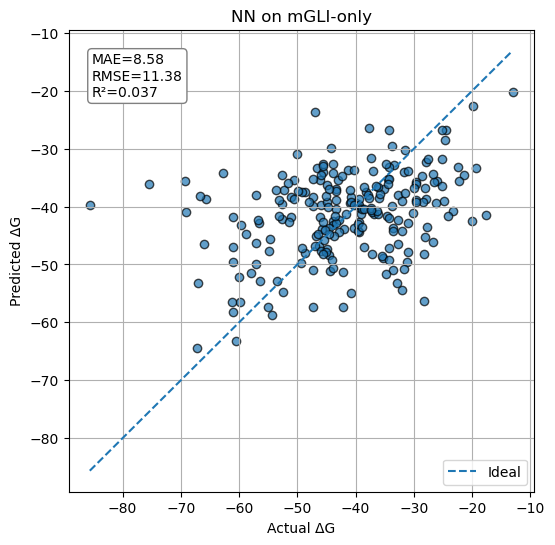

In [15]:
# Cell 6 — Evaluate & Plot

model.eval(); preds=[]
with torch.no_grad():
    for xb,_ in test_loader:
        xb=xb.to(device); preds.append(model(xb).cpu().numpy())
y_pred_z=np.vstack(preds).ravel()
y_pred=y_pred_z*sd_y+mu_y; y_true=y_te_z*sd_y+mu_y

m=metrics(y_true,y_pred)
print(f"[NN mGLI-only] Test | MSE {m['MSE']:.4f} MAE {m['MAE']:.3f} RMSE {m['RMSE']:.3f} R2 {m['R2']:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_true,y_pred,alpha=0.7,edgecolor="k")
mn,mx=float(y_true.min()),float(y_true.max())
plt.plot([mn,mx],[mn,mx],"--",label="Ideal")
plt.xlabel("Actual ΔG"); plt.ylabel("Predicted ΔG")
plt.title("NN on mGLI-only")
txt=f"MAE={m['MAE']:.2f}\nRMSE={m['RMSE']:.2f}\nR²={m['R2']:.3f}"
plt.annotate(txt,xy=(0.05,0.95),xycoords="axes fraction",va="top",ha="left",
             bbox=dict(boxstyle="round,pad=0.3",fc="white",ec="gray"))
plt.legend(); plt.grid(True); plt.show()


In [16]:
import os, re, math, random
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# --- EDIT THESE ---
TARGETS_TSV = "/home/op98/protein_design/topology/mGLI-PP/src/data/data_files/binding_affinity_two_proteins.tsv"
PT_DIR      = "/home/op98/protein_design/topology/mGLI-PP/src/data/data_files/pt"
# ------------------

SEED=42; VAL_SPLIT=0.15; TEST_SPLIT=0.15
BATCH_SIZE=128; LR=1e-3; EPOCHS=50  # tiny/fast
MGLI_DIM=1440                        # pad/trim to this
device="cuda" if torch.cuda.is_available() else "cpu"
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print("Device:", device)


Device: cpu


In [17]:
def norm_pdb(x:str)->str:
    s=str(x).strip().lower()
    m=re.search(r'([0-9a-z]{4})', s)
    return m.group(1) if m else s

def load_targets(path:str)->pd.DataFrame:
    df=pd.read_csv(path, sep=None, engine="python")
    df.columns=[c.strip() for c in df.columns]
    if "PDB_ID" in df.columns: df=df.rename(columns={"PDB_ID":"pdb_id"})
    if "ΔG_kJ/mol" in df.columns: df=df.rename(columns={"ΔG_kJ/mol":"delta_G"})
    if "deltaG" in df.columns: df=df.rename(columns={"deltaG":"delta_G"})
    assert "pdb_id" in df.columns and "delta_G" in df.columns
    df["JOIN_ID"]=df["pdb_id"].apply(norm_pdb)
    return df[["JOIN_ID","delta_G"]]

def load_mgli(pid:str)->np.ndarray|None:
    p=os.path.join(PT_DIR, f"{pid}_mGLI.pt")
    if not os.path.exists(p): return None
    v=torch.load(p, map_location="cpu")
    v=np.asarray(np.array(v).reshape(-1), dtype=np.float32)
    if v.size<MGLI_DIM: v=np.pad(v, (0,MGLI_DIM-v.size))
    elif v.size>MGLI_DIM: v=v[:MGLI_DIM]
    return v

def metrics(y, yhat):
    y=np.asarray(y).ravel(); yhat=np.asarray(yhat).ravel()
    mse=np.mean((yhat-y)**2); mae=np.mean(np.abs(yhat-y)); rmse=math.sqrt(mse)
    ss_tot=((y-y.mean())**2).sum(); ss_res=((y-yhat)**2).sum()
    r2=1-ss_res/ss_tot if ss_tot>0 else float("nan")
    return dict(MSE=mse, MAE=mae, RMSE=rmse, R2=r2)


In [18]:
df=load_targets(TARGETS_TSV)
pids=df["JOIN_ID"].tolist(); y_all=df["delta_G"].astype(np.float32).to_numpy()

X=[]; keep=[]
for i,p in enumerate(pids):
    v=load_mgli(p)
    if v is not None:
        X.append(v); keep.append(i)
X=np.stack(X,0).astype(np.float32)
y=y_all[keep]
print("Loaded:", X.shape, "targets:", y.shape)

# Split
idx=np.arange(len(y)); np.random.shuffle(idx)
n=len(idx); n_test=int(n*TEST_SPLIT); n_val=int(n*VAL_SPLIT)
te=idx[:n_test]; va=idx[n_test:n_test+n_val]; tr=idx[n_test+n_val:]

X_tr,X_va,X_te=X[tr],X[va],X[te]
y_tr,y_va,y_te=y[tr],y[va],y[te]

# Minimal, stable scaling (log1p + z-score on train)
X_tr=np.log1p(X_tr); X_va=np.log1p(X_va); X_te=np.log1p(X_te)
mu=X_tr.mean(0); sd=X_tr.std(0); sd[sd==0]=1
X_tr=(X_tr-mu)/sd; X_va=(X_va-mu)/sd; X_te=(X_te-mu)/sd

# Target mean only (leave in original scale for reporting by un-normalizing later if you wish)
mu_y=float(y_tr.mean()); sd_y=float(y_tr.std()) if y_tr.std()>0 else 1.0
y_tr_z=((y_tr-mu_y)/sd_y).astype(np.float32)
y_va_z=((y_va-mu_y)/sd_y).astype(np.float32)
y_te_z=((y_te-mu_y)/sd_y).astype(np.float32)

train_loader=DataLoader(TensorDataset(torch.from_numpy(X_tr),
                                      torch.from_numpy(y_tr_z[:,None])), batch_size=BATCH_SIZE, shuffle=True)
val_loader  =DataLoader(TensorDataset(torch.from_numpy(X_va),
                                      torch.from_numpy(y_va_z[:,None])), batch_size=BATCH_SIZE)
test_loader =DataLoader(TensorDataset(torch.from_numpy(X_te),
                                      torch.from_numpy(y_te_z[:,None])), batch_size=BATCH_SIZE)


/tmp/ipykernel_807943/2181885989.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  v=torch.load(p, map_location="cpu")


Loaded: (1492, 1440) targets: (1492,)


In [19]:
# Model: single Linear (ridge-ish via weight_decay)
model = nn.Linear(X_tr.shape[1], 1).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
lossf = nn.MSELoss()

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    tot=n=0
    for xb,yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        with torch.set_grad_enabled(train):
            pred = model(xb)
            loss = lossf(pred, yb)
            if train:
                opt.zero_grad(); loss.backward(); opt.step()
        tot += float(loss.item())*xb.size(0); n += xb.size(0)
    return tot/max(n,1)

best=float("inf"); wait=0; PATIENCE=10
for ep in range(1, EPOCHS+1):
    tr=run_epoch(train_loader, True)
    va=run_epoch(val_loader,   False)
    print(f"Epoch {ep:03d} | Train(z) {tr:.4f} | Val(z) {va:.4f}")
    if va<best-1e-8: best=va; best_state=model.state_dict(); wait=0
    else:
        wait+=1
        if wait>=PATIENCE:
            print("Early stop."); break
model.load_state_dict(best_state)


Epoch 001 | Train(z) 1.1424 | Val(z) 1.1330
Epoch 002 | Train(z) 0.9846 | Val(z) 1.1355
Epoch 003 | Train(z) 0.9103 | Val(z) 1.1061
Epoch 004 | Train(z) 0.8561 | Val(z) 1.0734
Epoch 005 | Train(z) 0.8217 | Val(z) 1.0422
Epoch 006 | Train(z) 0.7997 | Val(z) 1.0441
Epoch 007 | Train(z) 0.7766 | Val(z) 1.0707
Epoch 008 | Train(z) 0.7646 | Val(z) 1.0595
Epoch 009 | Train(z) 0.7518 | Val(z) 1.0769
Epoch 010 | Train(z) 0.7390 | Val(z) 1.0694
Epoch 011 | Train(z) 0.7358 | Val(z) 1.0660
Epoch 012 | Train(z) 0.7201 | Val(z) 1.0617
Epoch 013 | Train(z) 0.7113 | Val(z) 1.0773
Epoch 014 | Train(z) 0.6990 | Val(z) 1.0959
Epoch 015 | Train(z) 0.6930 | Val(z) 1.0901
Early stop.


<All keys matched successfully>

[Linear on mGLI] Test | MSE 138.9266  MAE 9.340  RMSE 11.787  R2 -0.033


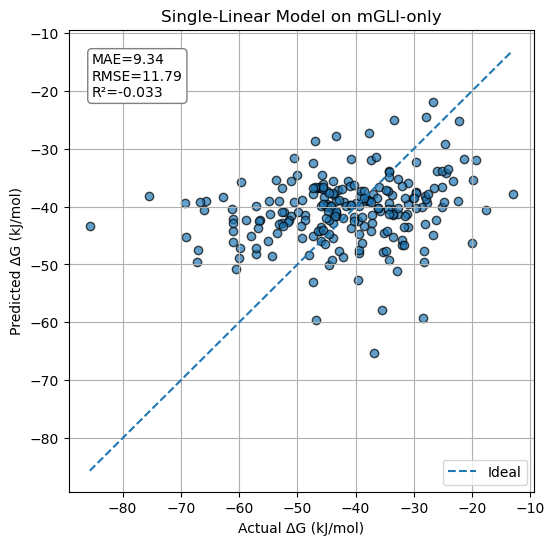

In [20]:
# Predict on test
model.eval(); preds=[]
with torch.no_grad():
    for xb,_ in test_loader:
        preds.append(model(xb.to(device)).cpu().numpy())
yhat_z=np.vstack(preds).ravel()
# back to kJ/mol
y_pred = yhat_z*sd_y + mu_y
y_true = y_te_z*sd_y + mu_y

m=metrics(y_true, y_pred)
print(f"[Linear on mGLI] Test | MSE {m['MSE']:.4f}  MAE {m['MAE']:.3f}  RMSE {m['RMSE']:.3f}  R2 {m['R2']:.3f}")

# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.7, edgecolor="k")
mn, mx = float(y_true.min()), float(y_true.max())
plt.plot([mn,mx],[mn,mx],'--',label="Ideal")
plt.xlabel("Actual ΔG (kJ/mol)"); plt.ylabel("Predicted ΔG (kJ/mol)")
plt.title("Single-Linear Model on mGLI-only")
txt=f"MAE={m['MAE']:.2f}\nRMSE={m['RMSE']:.2f}\nR²={m['R2']:.3f}"
plt.annotate(txt, (0.05,0.95), xycoords='axes fraction', va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'))
plt.legend(); plt.grid(True); plt.show()
